In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [1]:
def Sliding_Window(df_temp, win_len, stride):
    """
    Sliding window function for data segmentation and label extraction.
    
    Args:
        df_temp (DataFrame): Input dataframe containing the data.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.
    
    Returns:
        X (ndarray): Segmented input sequences.
        Y (ndarray): Extracted output labels.
        T (ndarray): Corresponding timestamps.
    """
    X = []  # List to store segmented input sequences.
    Y = []  # List to store extracted output labels.
    T = []  # List to store corresponding timestamps.

    # Loop through the dataframe with the specified stride.
    for i in np.arange(0, len(df_temp) - win_len, stride):
        # Extract a subset of the dataframe based on the window length.
        temp = df_temp.iloc[i:i + win_len, [3, 4]].values

        # Append the segmented input sequence to the X list.
        X.append(temp)

        # Append the output label at the end of the window to the Y list.
        Y.append(df_temp.iloc[i + win_len, -1])

        # Append the timestamp at the end of the window to the T list.
        T.append(df_temp.iloc[i + win_len, 0])

    return np.array(X), np.array(Y), np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes. 

In [4]:
def PreprocessData(working_cond, win_len, stride):
    """
    Preprocessing function to extract input sequences and output labels from CSV files of a specific working condition.

    Args:
        working_cond (str): Working condition identifier used to locate the folder containing CSV files.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X_full (ndarray): Concatenated segmented input sequences.
        Y_full (ndarray): Concatenated output labels.
    """
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path)

    X_full, Y_full = [], []  # Lists to store concatenated segmented input sequences and output labels

    for f in file_name:  # Iterate through each file, which corresponds to a fault
        csv_path = os.path.join(Path, f)
        df = pd.read_csv(csv_path)

        temp_df_1 = df[(df.time > 1050) & (df.time < 1500)]  # Incipient - Taking samples after which the parameter fault was introduced
        x1, y1, _ = Sliding_Window(temp_df_1, win_len, stride)

        temp_df_2 = df[(df.time > 2050) & (df.time < 2500)]  # Step - Taking samples after which the parameter fault was introduced
        x2, y2, _ = Sliding_Window(temp_df_2, win_len, stride)

        x_temp, y_temp = np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2), axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)

    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1, X_full.shape[2], X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [5]:
WL=20
S=40

# Preprocess data for working condition 120
X_120, Y_120 = PreprocessData(working_cond=120, win_len=WL, stride=S)

# Preprocess data for working condition 80
X_80, Y_80 = PreprocessData(working_cond=80, win_len=WL, stride=S)

# Preprocess data for working condition 40
X_40, Y_40 = PreprocessData(working_cond=40, win_len=WL, stride=S)

In [6]:
# Concatenate the preprocessed data from different working conditions
X_full = np.concatenate((X_40, X_80, X_120))
Y_full = np.concatenate((Y_40, Y_80, Y_120))

# Print the length of the total data
print(f"Length of total data = {len(X_full)}")

Length of total data = 5376


In [7]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, train_size=200, random_state=42)

# Standardising the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
# One Hot encoding
encoder = OneHotEncoder(sparse=False)
y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))

# CNN Model

In [21]:
def CNN_model(encoder,X_train_transformed):
    from tensorflow.keras.models import Sequential,Model
    from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
    from tensorflow.keras.layers import Conv1D, MaxPooling1D

    num_classes=len(encoder.categories_[0])

    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, kernel_size=(3),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    cnn_model.add(MaxPooling1D((2),padding='same'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return cnn_model

# AI Training

In [22]:
from sklearn.metrics import f1_score
import tensorflow

# Define an EarlyStopping callback to monitor validation accuracy and restore best weights
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create a CNN model using the specified encoder and X_train_sc
cnn_model = CNN_model(encoder, X_train_sc)

# Train the CNN model
cnn_model.fit(X_train_sc,
              y_train_ohe,
              epochs=200,
              batch_size=32,
              validation_data=(X_test_sc, y_test_ohe),
              callbacks=[callback],
              shuffle=False,
              verbose=1)

Epoch 1/200


7/7 [==============================] - 1s 126ms/step - loss: 1.9012 - accuracy: 0.4200 - val_loss: 1.5333 - val_accuracy: 0.7311
Epoch 2/200
7/7 [==============================] - 0s 76ms/step - loss: 1.3426 - accuracy: 0.7700 - val_loss: 1.1730 - val_accuracy: 0.8340
Epoch 3/200
7/7 [==============================] - 0s 73ms/step - loss: 1.0230 - accuracy: 0.8450 - val_loss: 0.9152 - val_accuracy: 0.8526
Epoch 4/200
7/7 [==============================] - 0s 74ms/step - loss: 0.8052 - accuracy: 0.8650 - val_loss: 0.7396 - val_accuracy: 0.8603
Epoch 5/200
7/7 [==============================] - 0s 74ms/step - loss: 0.6523 - accuracy: 0.8750 - val_loss: 0.6114 - val_accuracy: 0.8655
Epoch 6/200
7/7 [==============================] - 0s 76ms/step - loss: 0.5381 - accuracy: 0.8800 - val_loss: 0.5108 - val_accuracy: 0.9473
Epoch 7/200
7/7 [==============================] - 0s 76ms/step - loss: 0.4477 - accuracy: 0.9900 - val_loss: 0.4288 - val_accuracy: 0.9921
Epoch 8/200
7/7 [==============

In [23]:
# Perform prediction using the CNN model on the scaled test data
y_pred = cnn_model.predict(X_test_sc)

# Inverse transform the predicted labels using the encoder
y_pred = encoder.inverse_transform(y_pred)

# Calculate and print the F1 score
f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Train Sample = {len(X_train)}, The F1 score is - {f1score}")


Train Sample = 200, The F1 score is - 0.9920799901759411


# Real Time Fault Diagnosis

In [24]:
# Dictionary mapping fault labels to their corresponding numeric values
fault_label_dict = {
    'Healthy': 0,
    'I': 3,
    'I & W': 7,
    'K': 5,
    'Re': 1,
    'Re & Rm': 6,
    'Rm': 2,
    'W': 4
}

In [25]:
'''fault_file = 'Healthy_noise_02.csv',
'I & W_noise_02.csv',
'I_noise_02.csv',
'K_noise_02.csv',
'Re & Rm_noise_02.csv',
'Re_noise_02.csv',
'Rm_noise_02.csv',
'W_noise_02.csv'''
def Predict_CNN(fault_file,working_cond, cnn_model, scaler, encoder, WL, S):
    """
    Predict fault labels using a trained CNN model.

    Args:
        fault_file (str): Name of the fault file to predict labels for.
        cnn_model (Model): Trained CNN model for fault prediction.
        scaler (Scaler): Scaler object for data normalization.
        encoder (Encoder): Encoder object for label encoding.
        WL (int): Length of the sliding window.
        S (int): Stride or step size for sliding the window.

    Returns:
        y_pred_num (ndarray): Predicted fault labels in numerical format.
        y_true_num (ndarray): True fault labels in numerical format.
        t1 (ndarray): Corresponding timestamps.
    """
    # Construct the path to the fault file
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
    csv_path = os.path.join(Path, fault_file)
    df = pd.read_csv(csv_path)

    # Perform sliding window operation on the data
    x1, y1, t1 = Sliding_Window(df, win_len=WL, stride=S)

    # Normalize the input data using the provided scaler
    x_sc = scaler.transform(x1.reshape(-1, x1.shape[-1])).reshape(x1.shape)

    # Make predictions using the CNN model
    y_pred = cnn_model.predict(x_sc)
    y_pred = encoder.inverse_transform(y_pred)

    # Convert the predicted labels to numerical format
    y_pred_num = np.vectorize(fault_label_dict.get)(y_pred)
    y_pred_num = y_pred_num.reshape(-1)

    # Convert the true labels to numerical format
    y_true_num = np.vectorize(fault_label_dict.get)(y1)
    y_true_num = y_true_num.reshape(-1)

    return y_pred_num, y_true_num, t1

In [26]:
def plot_online_FDI(y_pred_num, y_true_num, t1,Title):
    """
    Function to plot online fault detection and identification (FDI) results.

    Args:
        y_pred_num (ndarray): Predicted fault class values.
        y_true_num (ndarray): Actual fault class values.
        t1 (ndarray): Time values.

    Returns:
        None (displays the plot).
    """
    plt.subplots(figsize=(8, 3))

    sns.scatterplot(x=t1, y=y_pred_num, hue=y_true_num, palette="bright", edgecolor='black', alpha=0.5, s=30)

    # Add labels and title
    plt.xlabel('time (s)', fontsize=10)
    plt.ylabel('Predicted fault class', fontsize=10)

    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7])
    plt.ylim([-.5, 7.5])
    plt.legend(markerscale=1.5, bbox_to_anchor=(1.01, 1.05), title='Actual fault class', fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.axvspan(xmin=1000, xmax=1500, facecolor='r', alpha=0.2)
    plt.axvspan(xmin=2000, xmax=2500, facecolor='r', alpha=0.2)
    plt.title(Title)
    # Display the plot
    plt.show()

Introduced fault is Healthy


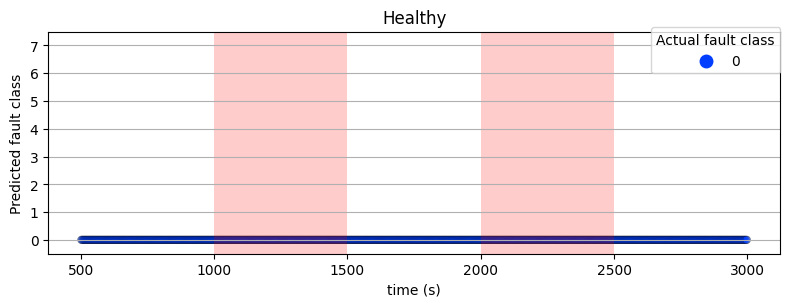

Introduced fault is I & W


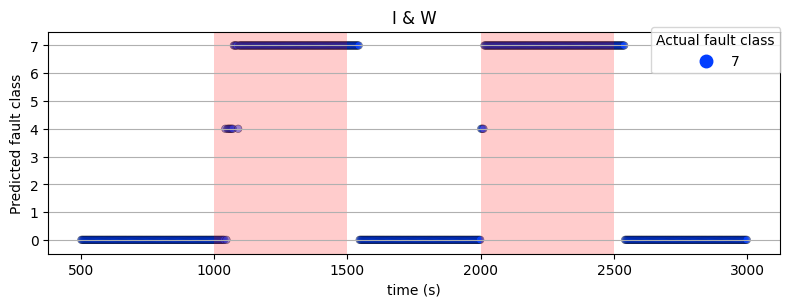

Introduced fault is I


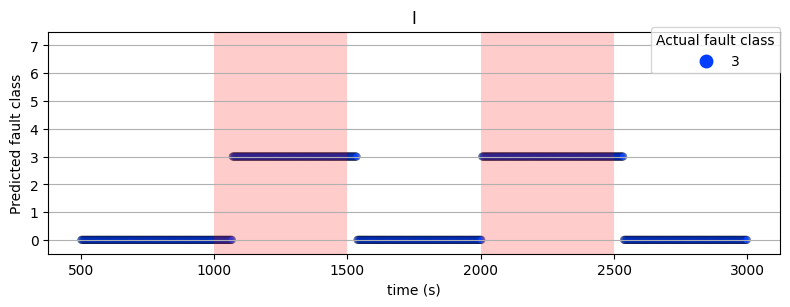

Introduced fault is K


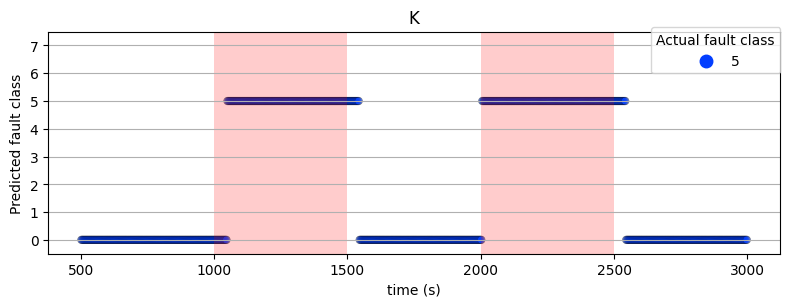

Introduced fault is Re & Rm


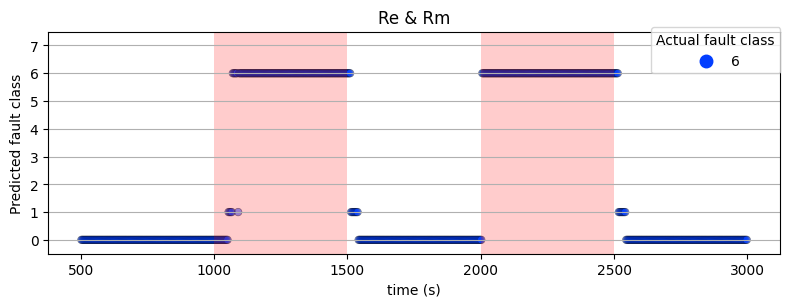

Introduced fault is Re


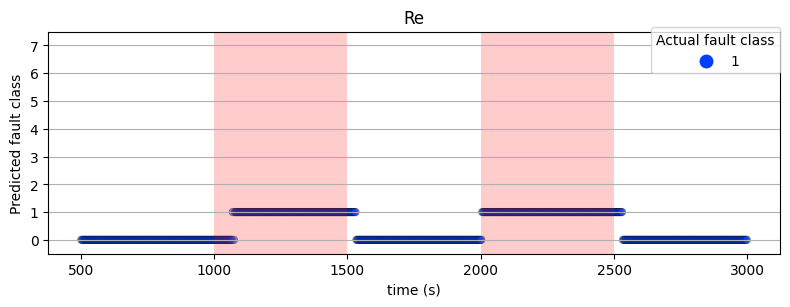

Introduced fault is Rm


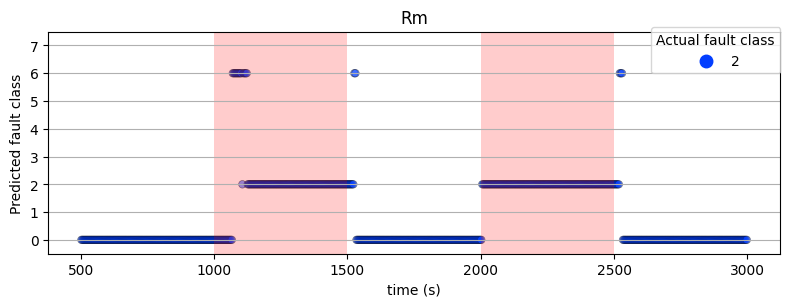

Introduced fault is W


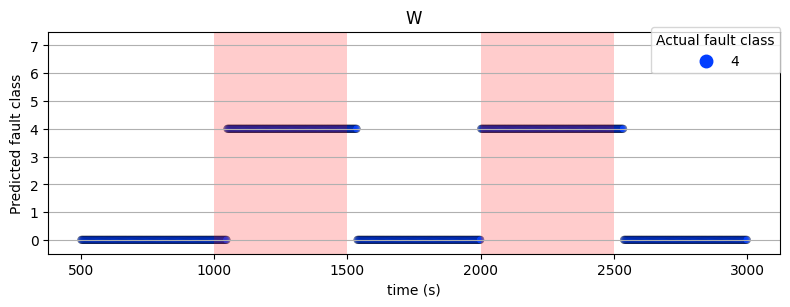

In [27]:
file_name = ['Healthy_noise_02.csv',
            'I & W_noise_02.csv',
            'I_noise_02.csv',
            'K_noise_02.csv',
            'Re & Rm_noise_02.csv',
            'Re_noise_02.csv',
            'Rm_noise_02.csv',
            'W_noise_02.csv']

for f in file_name:
    # Extract the fault type from the file name
    fault_type = f[:-13]
    
    print(f"Introduced fault is {fault_type}")
    
    # Perform fault diagnosis using the CNN model
    y_pred_num, y_true_num, t1 = Predict_CNN(fault_file=f, working_cond=40, cnn_model=cnn_model, scaler=scaler, encoder=encoder, WL=WL, S=S)
    
    # Plot online fault detection and isolation results
    plot_online_FDI(y_pred_num, y_true_num, t1,Title=fault_type)